In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Gensim
from gensim.corpora.dictionary import Dictionary

In [2]:
# Read Data
df = pd.read_csv('construction_review.csv')
# 결측치 제거
df = df.dropna()
adv = df['adv'] # Advantage review
dadv = df['dadv'] # Disadvantage review
df.head()

,Unnamed: 0,cmp,adv,dadv
0,0,한국토지주택공사,공공기관 특성상 상대적으로 자유로운 휴가사용이 가능하다는것.전문자격증 취득을 원할경...,1.쓸데없는 자료요청과 잦은 회의 수직적구조2.노력대비 적은보상3.브랜드이미지 최하...
1,1,한전KPS(주),연봉 초임4넘고 3년차기준 5천넘어가며높은워라벨을즐김 공기업답게 워라벨이 좋고 복지...,돈은많이 벌지만 그돈이 오지생활이기에 술값으로 다나감. 발전소에서 근무를 하게 되면...
2,2,현대엔지니어링(주),계약직이어서 복지는 거의 해당이 없었지만 그래도 대기업인 만큼 사람들도 괜찮고 분위...,급여가 좀 적고 남녀성비가 안맞는게 단점이라면 단점이지만 나랑은 잘 맞았음 예산 사...
3,3,현대건설(주),연차를 자유롭게 사용가능. 현장에 따라서 자유로운 분위기 연차를 윗사람과 많이 겹치...,복지제도가 많으나 쓰기가 힘들고 아직 건설업의 문화가 남아있음 업무가 소장의 지시에...
4,4,(주)대우건설,대우 직원 분들 정이 많고 잘 챙겨주십니다.사람마다 케바케지만 대부분 정많고 오래 ...,중흥에서 인수하면서 회사 체계가 나락으로 가고 있음... 독자경영 약속하고 인수한거...


In [3]:
# Word Count
from konlpy.tag import Okt

t = Okt()

def my_tokenizer(doc):
    return [
        token
        for token, pos in t.pos(doc)
        if pos == 'Noun' and len(token)>1
    ]

In [6]:
texts = [my_tokenizer(text) for text in df.adv]

In [12]:
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:',len(dictionary))

dictionary.filter_extremes(keep_n = 2000, no_below = 10, no_above = 0.5)
print("#Number of unique words after removing rae and common words:", len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 3998
#Number of unique words after removing rae and common words: 480
#Number of unique tokens: 480
#Number of documents: 108


In [14]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
model = LdaModel(corpus = corpus, id2word = dictionary,passes = passes, num_topics = num_topics,random_state = 7)

In [15]:
model.print_topics(num_words=10)

[(0,
  '0.025*"대기업" + 0.023*"프로젝트" + 0.016*"시스템" + 0.016*"건설" + 0.014*"할인" + 0.013*"식대" + 0.011*"성과급" + 0.010*"선물" + 0.009*"규모" + 0.009*"커리어"'),
 (1,
  '0.018*"때문" + 0.015*"점심" + 0.013*"건설" + 0.012*"사내" + 0.011*"신입" + 0.011*"식당" + 0.011*"휴무" + 0.010*"출퇴근" + 0.009*"구내식당" + 0.009*"기준"'),
 (2,
  '0.022*"경력" + 0.021*"건설" + 0.017*"개인" + 0.016*"법카" + 0.016*"카드" + 0.015*"도급" + 0.014*"순위" + 0.013*"기준" + 0.011*"입사" + 0.010*"토목"'),
 (3,
  '0.038*"공기업" + 0.019*"초봉" + 0.018*"보장" + 0.017*"강도" + 0.015*"기술" + 0.014*"경우" + 0.013*"기간" + 0.012*"도서" + 0.011*"숙소" + 0.010*"사택"'),
 (4,
  '0.052*"공기업" + 0.027*"보장" + 0.022*"정년" + 0.014*"강도" + 0.013*"본인" + 0.012*"포인트" + 0.012*"수평" + 0.010*"교육" + 0.010*"때문" + 0.010*"개인"'),
 (5,
  '0.020*"사옥" + 0.017*"건물" + 0.016*"식대" + 0.009*"지급" + 0.009*"서울" + 0.009*"부바" + 0.008*"신입" + 0.008*"노력" + 0.008*"숙소" + 0.008*"거의"'),
 (6,
  '0.029*"건설" + 0.016*"대기업" + 0.013*"수준" + 0.012*"숙소" + 0.010*"시스템" + 0.009*"건설업" + 0.009*"그룹" + 0.009*"식대" + 0.008*"수평" + 0.008*"정규직"'),
 (7,
  '0.0

In [16]:
print('#topic distribution of the first document:',model.get_document_topics(corpus)[0])

#topic distribution of the first document: [(3, 0.53063893), (9, 0.4685849)]


In [20]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model= model, corpus= corpus, coherence= 'u_mass')
coherence = cm.get_coherence()
print(coherence)

-0.8803410016146204


num_topics: 6, perplexity: -6.227, coherence: -0.720
num_topics: 7, perplexity: -6.274, coherence: -0.753
num_topics: 8, perplexity: -6.329, coherence: -0.746
num_topics: 9, perplexity: -6.372, coherence: -0.777
num_topics: 10, perplexity: -6.434, coherence: -0.756
num_topics: 11, perplexity: -6.495, coherence: -0.777
num_topics: 12, perplexity: -6.540, coherence: -0.772
num_topics: 13, perplexity: -6.605, coherence: -0.754
num_topics: 14, perplexity: -6.662, coherence: -0.745
num_topics: 15, perplexity: -6.703, coherence: -0.790
num_topics: 16, perplexity: -6.752, coherence: -0.769
num_topics: 17, perplexity: -6.810, coherence: -0.786
num_topics: 18, perplexity: -6.841, coherence: -0.790
num_topics: 19, perplexity: -6.927, coherence: -0.811
num_topics: 20, perplexity: -6.955, coherence: -0.799
num_topics: 21, perplexity: -7.025, coherence: -0.785
num_topics: 22, perplexity: -7.074, coherence: -0.787
num_topics: 23, perplexity: -7.147, coherence: -0.785
num_topics: 24, perplexity: -7.1

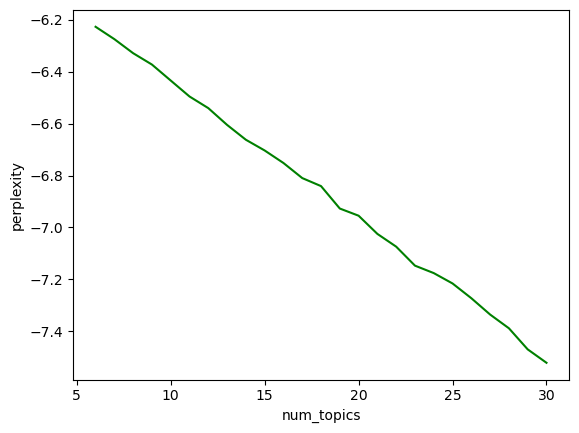

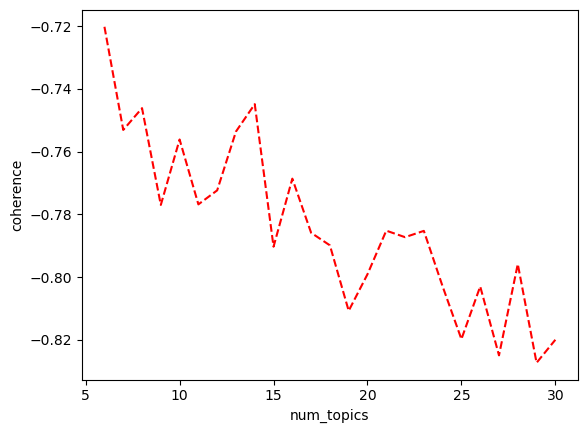

In [24]:
def show_coherence(corpus, dictionary, start = 6, end = 15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end+1):
        model = LdaModel(corpus = corpus, id2word = dictionary, chunksize=1000, num_topics = i,random_state = 7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')
    
    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start = 6, end = 30)